In [1]:
import torch, torchvision, numpy as np, matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torchvision.utils as vutils
torch.backends.cudnn.benchmark = True
device = torch.device('cuda') 

# Конфигурирование

In [2]:
config = {
    "dataset": {
        "train": {
            "table": "./data/train.csv",
            "data": "./data/bare_data/"
        },
        "val": {
            "table": "./data/val.csv",
            "data": "./data/bare_data/"
        }
    },
    "train": {
        "batch_size": 256,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': True,
        'pin_memory': True,
    },
    "val": {
        "batch_size": 256,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': False,
        'pin_memory': True,
    },
    "vae": {
        "freq": 16000,
        "lenght": 5,
    },
    "model": {
        "latent_size": 128,
        "epochs": 15,
        "learning_rate": 0.001,
        "freq_scale": 4,
        "time_scale": 4,
    },
    "utils": {
        "n_fft": 800, # TODO
    }
}

# Загрузка данных

In [3]:
import os
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, table_path, data_path, transforms=None):
        self.table = pd.read_csv(table_path)
        self.data_path = data_path
        self.transforms = transforms
    def __getitem__(self, idx):
        file_path = self.table.loc[idx, 'file'] # TODO починить
        if isinstance(file_path, str):
            path = os.path.join(self.data_path, file_path)
            audio, _ = torchaudio.load(path, channels_first=True)
            if self.transforms:
                return self.transforms(audio[0:].squeeze())
            return audio[0:].squeeze()
        else:
            return None
    def __length__(self):
        return len(self.table) # TODO починить

In [4]:
def get_dataloader(config, dataset_type, transforms):
    dataset = AudioDataset(
            config['dataset'][dataset_type]['table'],
            config['dataset'][dataset_type]['data'],
            transforms
        )
    dataloader = torch.utils.data.DataLoader(
            dataset,
            config[dataset_type]['batch_size'],
            config[dataset_type]['shuffle'],
            pin_memory=config[dataset_type]['pin_memory'],
        )
    return dataloader

# Аугментации

In [5]:
augs = torch.nn.Sequential([
    torchaudio.transforms.Spectrogram(n_fft=config['utils']['n_fft']), # TODO навставлять сюда гадостей из конфига
    torchaudio.transforms.MelScale(),
])

NameError: name 'torchaudio' is not defined

# ВАЕ

Автоэнкодер = Энкодер + Декодер

Энкодер --- берет объект, сжимает его в какое-то пространство (латентное пространство, а его элемент --- латент)

Декодер --- берет латент и разжимает его в объект



### Примеры AE


In [ ]:
class SimpleAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__(self)
        self.encoder = nn.Linear(input_size, latent_size) # Можем поменять на какую-нибудь сложную модель
        self.decoder = nn.Linear(latent_size, input_size) # Можем поменять на какую-нибудь сложную модель 2

    def encode(self, x): # возвращает latent
        return self.encoder(x)

    def decode(self, latent): # принимает latent
        return self.decoder(latent)

    def forward(self, x):
        latent = self.encode(x)
        y = self.decode(latent)
        return y


# model = SimpleAE()
# for obj in dataloader:
#   pred = model(obj)
#   loss = L2Loss(pred, obj) # Reconstustion loss
#   loss.backward()
#   optimizer.step()
#   optimizer.zero_grads()

In [ ]:
class SimpleVAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__(self)
        self.encoder = nn.Linear(input_size, latent_size) # Можем поменять на какую-нибудь сложную модель
        self.encoder_mu = nn.Linear(latent_size, latent_size) #
        self.encoder_sigma = nn.Linear(latent_size, latent_size) #
        self.decoder = nn.Linear(latent_size, input_size) # Можем поменять на какую-нибудь сложную модель 2
        # ! ЛАТЕНТ должен быть из распределения $(N=latent_size) N-мерного ШАРА

    def encode(self, x): # возвращает latent
        x = self.encoder(x)
        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        return mu, sigma

    def decode(self, latent): # принимает latent
        return self.decoder(latent)

    def forward(self, x):
        mu, sigma = self.encode(x)
        #z = mu + sigma*rand()
        y = self.decode(z)
        return y
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

# model = SimpleAE()
# for obj in dataloader:
#   pred_latent = model.encode(obj)
#   pred = model.decode(pred_latent)
#   rec_loss = L2Loss(pred, obj) # Reconstustion loss
#   dist_loss = KL_Loss(pred_latent, torch.random.normal_like(pred_latent)) # Reconstustion loss
#   loss = rec_loss+dist_loss
#   loss.backward()
#   optimizer.step()
#   optimizer.zero_grads()

## Модель


### Н-мерные случайные шары

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
N = 1000
X = np.random.normal(0, 1, N)
Y = np.random.normal(0, 1, N)

In [ ]:
import matplotlib as mpl
import matplotlib.patches as ptch
plt.hist(X, bins=100)
plt.show()

plt.scatter(X, np.random.uniform(-1, 1, N), np.ones_like(X)*2)
plt.title("1d случайный гауссов шар")
plt.grid()
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.show()

fig, ax = plt.subplots()
plt.scatter(X, Y, np.ones_like(X)*2)
circle3 = ptch.Circle((0, 0), 3, color='r', fill=False)
circle2 = ptch.Circle((0, 0), 2, color='g', fill=False)
circle1 = ptch.Circle((0, 0), 1, color='b', fill=False)
ax.add_patch(circle1)
ax.add_patch(circle3)
ax.add_patch(circle2)
ax.set_aspect('equal')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title("2d случайный гауссов шар")
plt.grid()
plt.show()

### Код

In [4]:
class VAE_Audio(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder_input = nn.Sequential(
                nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.GELU(),
                nn.Conv2d(64,  32, 3, 1, 1), nn.BatchNorm2d(32),  nn.GELU(),
         )
        self.encoder_squeeze = nn.Sequential(
                nn.Conv2d(32, 32, 3, 2, 1), nn.GELU(), 
                nn.Conv2d(32, 32, 3, 2, 1), nn.GELU(), 
        )
        self.encoder_mu     = nn.Conv2d(32, 64, 1)
        self.encoder_logvar = nn.Conv2d(32, 64, 1)
        self.decoder_unsqueeze = nn.Sequential(
                nn.ConvTranspose2d(64, 64, 3, 2, 1, output_padding=1), nn.GELU(),
                nn.ConvTranspose2d(64,  32, 3, 2, 1, output_padding=1), nn.GELU(),
        )
        self.decoder_output = nn.Sequential(
                 nn.ConvTranspose2d(32, 8, 3, 1, 1), nn.GELU(),
                 nn.BatchNorm2d(8),
                 nn.ConvTranspose2d(8, 1, 3, 1, 1), 
        )
    def encode(self, x):
        x = self.encoder_input(x)
        x = self.encoder_squeeze(x)
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar
    def sample(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std*eps
        return z, mu, logvar
    def decode(self, x):
        x = self.decoder_unsqueeze(x)
        x = self.decoder_output(x)
        return x
    def KLD_loss(self, mu, logvar, q=0.02):
        kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld = torch.clamp(kld, min=q)
        return kld.mean()
    def forward(self, x):
        z, mu, logvar = self.sample(x)
        return self.decode(z), z, mu, logvar     

In [5]:
from tqdm.auto import tqdm
class AvegereMeter:
    def __init__(self,):
        self.arr = []
    def __call__(self, item, n=1):
        if n<=1:
            self.arr.extend([item])
        else:
            self.arr.extend([item]*n)
    def __str__(self,) -> str:
        return str(np.mean(np.array(self.arr)))
    def zero(self,):
        self.arr=[]

class VAE_Trainer:
    def __init__(self, model, train_dataloader, val_dataloader,):
        self.model = model
        self.device = next(model.parameters()).device
        self.tdl = train_dataloader
        self.vdl = val_dataloader
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
        self.rec_loss = nn.BCEWithLogitsLoss(reduction='mean') 
        self.loss_meter = AvegereMeter()
        # self.scheduler

    def train_loop(self, k=0.01):
        self.model.train()
        self.loss_meter.zero()
        for audio, _ in tqdm(self.tdl, desc = 'train'):
            audio = audio.to(self.device)
            assert audio.is_cuda, "WTF, CPU?"
            z, mu, logvar = self.model.sample(audio)
            output = self.model.decode(z)
            recon = self.rec_loss(output, audio) 
            KLD = self.model.KLD_loss(mu, logvar)
            loss = recon + k * KLD
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.loss_meter(loss.item(), audio.size(0))
        #self.scheduler.step()
        print("Loss = "+self.loss_meter.__str__())
    def val_loop(self):
        self.model.eval()
        self.loss_meter.zero()
        for audio, _ in tqdm(self.vdl):
            with torch.no_grad():
                audio = audio.to(self.device)
                assert audio.is_cuda, "WTF, CPU?"
                z, mu, logvar = self.model.sample(audio)
                output = self.model.decode(mu)
                loss = self.rec_loss(output, audio)
                self.loss_meter(loss.item(), audio.size(0))
        print("Val loss = "+self.loss_meter.__str__())


In [7]:
vae = VAE_Audio().to(device)
assert next(vae.parameters()).device.type == 'cuda', "WTF, CPU?"
transform = transforms.Compose([transforms.ToTensor()])
train_ds = torchvision.datasets.MNIST('./data', train=True,  download=True, transform=transform)
val_ds   = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=config['train']['batch_size'], shuffle=True,  num_workers=8, pin_memory=config['train']['pin_memory'])
val_dataloader   = DataLoader(val_ds,   batch_size=config['val']['batch_size'], shuffle=False, num_workers=8, pin_memory=config['val']['pin_memory'])
trainer = VAE_Trainer(vae, train_dataloader, val_dataloader)
# EPOCHS = 10
# for epoch in range(EPOCHS):
#     beta = 0.01 * min(1., (epoch + 1) / 20)
#     print(f"\nEpoch {epoch+1}/{EPOCHS}   beta={beta:.4f}")
#     trainer.train_loop(beta)
#     trainer.val_loop()
# torch.save(vae.state_dict(), "vae_GPUv4.pt")


C:\Users\User\AppData\Local\Temp\ipykernel_23704\3209773592.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("vae_GPUv4.pt", map_location=device)   # ←

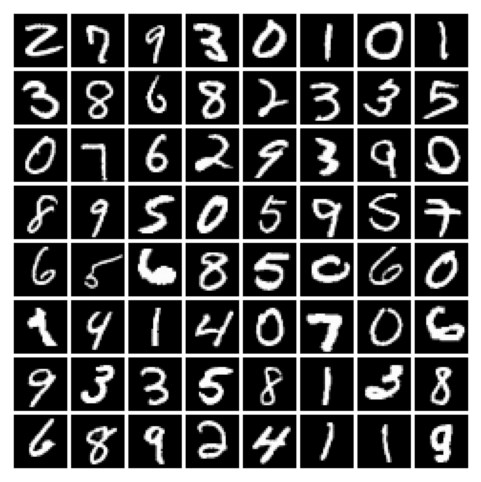

Готово: posterior_random_samples.png


In [10]:
import torch, matplotlib.pyplot as plt, torchvision.utils as vutils
vae = VAE_Audio().to(device)
state = torch.load("vae_GPUv4.pt", map_location=device)
vae.load_state_dict(state)
vae.eval()
device = next(vae.parameters()).device


mu_bank, std_bank = [], []
with torch.no_grad():
    for x, _ in train_dataloader:
        x = x.to(device, non_blocking=True)
        mu, logvar = vae.encode(x)
        mu_bank.append(mu)
        std_bank.append((0.5*logvar).exp())
        if len(mu_bank) * x.size(0) >= 10_000: 
            break

mu_bank  = torch.cat(mu_bank)   # (10k,64,7,7)
std_bank = torch.cat(std_bank)  # (10k,64,7,7)

idx   = torch.randint(0, mu_bank.size(0), (64,))
mu_s  = mu_bank[idx]            # (64,64,7,7)
std_s = std_bank[idx]

z = mu_s + 0.1 * std_s * torch.randn_like(mu_s)

with torch.no_grad():
    imgs = torch.sigmoid(vae.decode(z)).cpu()    # (64,1,28,28)

grid = vutils.make_grid(imgs, nrow=8, pad_value=1)
plt.figure(figsize=(6,6)); plt.axis('off')
plt.imshow(grid.permute(1,2,0)); plt.show()

vutils.save_image(imgs, 'posterior_random_samples.png', nrow=8)
print("Готово: posterior_random_samples.png")

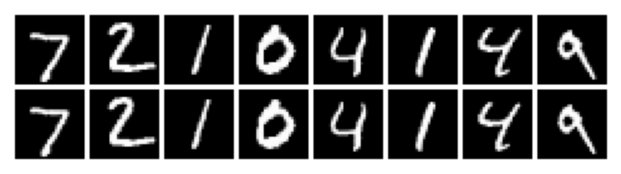

In [11]:
import torchvision.utils as vutils, matplotlib.pyplot as plt
imgs, _ = next(iter(val_dataloader))
imgs = imgs.to(device)

with torch.no_grad():
    mu, _   = vae.encode(imgs)                     # ← 1× вызов encode
    recon   = torch.sigmoid(vae.decode(mu))        # 28×28

grid = vutils.make_grid(
    torch.cat([imgs.cpu()[:8], recon.cpu()[:8]]),  # верх/низ
    nrow=8, pad_value=1
)
plt.figure(figsize=(8,2)); plt.axis('off')
plt.imshow(grid.permute(1,2,0)); plt.show()

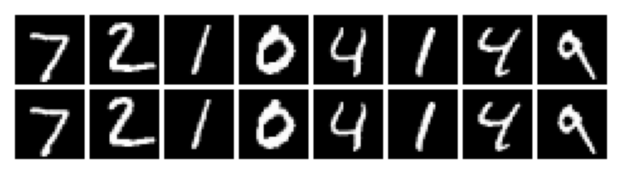

In [12]:
imgs, _ = next(iter(val_dataloader))
imgs = imgs.to(device)

with torch.no_grad():
    mu, logvar = vae.encode(imgs)
    z   = mu + 0.05 * torch.exp(0.5*logvar) * torch.randn_like(mu)  # лёгкий сдвиг
    recon = torch.sigmoid(vae.decode(z))

grid = vutils.make_grid(torch.cat([imgs.cpu()[:8], recon.cpu()[:8]]), nrow=8, pad_value=1)
plt.figure(figsize=(8,2)); plt.axis('off'); plt.imshow(grid.permute(1,2,0)); plt.show()

# ДОМАШКА 1

Обучить наш VAE на MNIST что бы на входе и выходе была одна и та же картинка (бонус если выучите расшумлять), порисовать на подвыборках мниста графики точечек нашего латентного пространства (сделать PCA/t-SNE что бы сжать в 2d/3d)

C:\Users\User\AppData\Local\Temp\ipykernel_23704\4203386438.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_GPUv4.pt", map_location=d

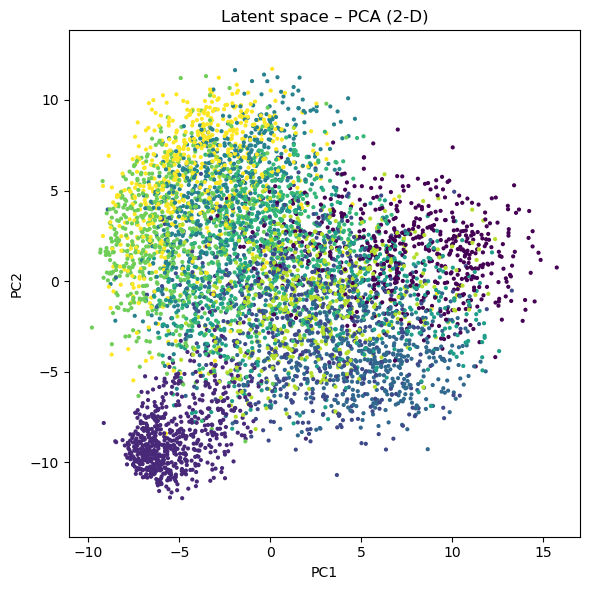

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
from sklearn.manifold import TSNE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE_Audio().to(device)
vae.load_state_dict(torch.load("vae_GPUv4.pt", map_location=device))
vae.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in val_dataloader:
        mu, _ = vae.encode(x.to(device))              # (B, C, 7, 7)
        latents.append(mu.view(mu.size(0), -1).cpu()) # → (B, C*7*7)
        labels.extend(y.numpy())
        if len(labels) >= 6000:                       # хватит 6k точек
            break

Z = torch.cat(latents)[:6000].numpy()
labels = np.array(labels)[:6000]

# --- 2.  PCA-проекция -------------------------------------------------------
Z_pca = PCA(n_components=2).fit_transform(Z)

plt.figure(figsize=(6,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], s=4, c=labels)
plt.title('Latent space – PCA (2-D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.axis('equal'); plt.tight_layout(); plt.show()

# --- 3.  t-SNE-проекция -----------------------------------------------------
Z_tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='pca').fit_transform(Z)

plt.figure(figsize=(6,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], s=4, c=labels)
plt.title('Latent space – t-SNE (2-D)')
plt.xlabel('t-SNE-1'); plt.ylabel('t-SNE-2')
plt.axis('equal'); plt.tight_layout(); plt.show()


In [12]:
import torch, sys
print("cuda available:", torch.cuda.is_available())
print("python exe    :", sys.executable)


cuda available: True
python exe    : C:\Users\User\anaconda3\python.exe


# Домашка 2

In [ ]:
# Обучить VAE на аудио (любой датасет со звуками речи, нарезать на маленькие кусочки (0.1 -- 3 сек), дописать загрузку и выгрузку, сделать обрезку выхода до размера входа в трейне и вале)